# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import datetime
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
mini_df = spark.read.json("mini_sparkify_event_data.json")
mini_df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
mini_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
mini_df.count()

286500

In [6]:
mini_df.select("userId").dropDuplicates().count()

226

Firstly we will drop all the data without userId and sessionId.

In [5]:
mini_df_clean = mini_df.dropna(how = "any", subset = ["userId", "sessionId"])
mini_df_clean.count()

286500

Also, we need to clean the data where userId and sessionId is empty.

In [7]:
mini_df_clean = mini_df_clean.where(mini_df.userId != "")
mini_df_clean.show()
mini_df_clean.count()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

278154

In [10]:
mini_df_clean.where(mini_df_clean.song != "null").select(["song", "length"]).dropDuplicates().describe(["length"]).show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|             65959|
|   mean|247.89207490456192|
| stddev|104.99056377693502|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [19]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
mini_df_clean = mini_df_clean.withColumn("hour", get_hour(mini_df_clean.ts))
mini_df_clean.filter(mini_df_clean.page == "NextSong") \
    .groupby(mini_df_clean.hour).count().orderBy(mini_df_clean.hour.cast("float")).show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
|  20|10856|
|  21|10458|
|  22|10122|
|  23| 9630|
+----+-----+



In [12]:
mini_df_clean.where(mini_df_clean.length == 0.78322).show()

+--------+---------+---------+------+-------------+----------+-------+-----+-----------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  artist|     auth|firstName|gender|itemInSession|  lastName| length|level|         location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------+---------+---------+------+-------------+----------+-------+-----+-----------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Dorantes|Logged In|Elizabeth|     F|           47|Washington|0.78322| paid|Oklahoma City, OK|   PUT|NextSong|1532472246000|     1599|La Danza De Las S...|   200|1542579601000|"Mozilla/5.0 (Mac...|   120|
+--------+---------+---------+------+-------------+----------+-------+-----+-----------------+------+--------+-------------+---------+--------------------+------+-------------+----

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Firstly we will look into the possible pages that a user can access.

In [8]:
mini_df_clean.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Secondly we can check how user would interact with the system.

In [9]:
mini_df_clean.where(mini_df_clean.page == "Cancellation Confirmation").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|


In [10]:
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
mini_df_clean = mini_df_clean.withColumn("cancelled", flag_cancel_event("page"))

In [11]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
minidf_withchurn = mini_df_clean.withColumn("churn", Fsum("cancelled").over(windowval))

In [12]:
minidf_withchurn.select(["userId", "ts", "page", "level", "churn", "cancelled"]).where(minidf_withchurn.userId == "125").sort("ts").collect()

[Row(userId='125', ts=1539317144000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539317481000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539317711000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539317914000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318124000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318515000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318728000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318906000, page='NextSong', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318917000, page='Roll Advert', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318918000, page='Cancel', level='free', churn=1, cancelled=0),
 Row(userId='125', ts=1539318918000, page='Cancellation Confirmation', level='free', chur

In [13]:
minidf_withchurn.where(minidf_withchurn.userId == "125").sort("ts").show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|cancelled|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|    paranoid android|   200|1539317144000|"Mozilla/5.0 (Mac...|   125|        0|    1|
|The Notorious B

In [14]:
churned_users = minidf_withchurn.where(minidf_withchurn.churn == 1).select("userId").dropDuplicates()
churned_users.show()
churned_users.count()

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
+------+
only showing top 20 rows



52

In [15]:
unchurned_users = minidf_withchurn.where(minidf_withchurn.churn == 0).select("userId").dropDuplicates()
unchurned_users.show()
unchurned_users.count()

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



225

We can check whether the churned users access the page differently comparing to nor churned users by checking average page access frequency.

In [16]:
churned_df = minidf_withchurn.where(minidf_withchurn.churn == 1)
churned_count = churned_df.count()
churned_pagecounts = churned_df.select("page").groupby(["page"]).count()
churned_pagecounts = churned_pagecounts.withColumn("PageFreq", churned_pagecounts["count"] / churned_count).sort("page")

unchurned_df = minidf_withchurn.where(minidf_withchurn.churn != 1)
unchurned_count = unchurned_df.count()
unchurned_pagecounts = unchurned_df.select("page").groupby(["page"]).count()
unchurned_pagecounts = unchurned_pagecounts.withColumn("ucPageFreq", unchurned_pagecounts["count"] / unchurned_count).sort("page")

In [17]:
churned_pagecounts.show()

+--------------------+-----+--------------------+
|                page|count|            PageFreq|
+--------------------+-----+--------------------+
|               About|   56|0.001248216833095...|
|          Add Friend|  636|0.014176176890156919|
|     Add to Playlist| 1038|0.023136590584878745|
|              Cancel|   52|0.001159058487874...|
|Cancellation Conf...|   52|0.001159058487874...|
|           Downgrade|  337|0.007511590584878745|
|               Error|   32|7.132667617689016E-4|
|                Help|  239|0.005327211126961484|
|                Home| 1672|0.037268188302425106|
|              Logout|  553| 0.01232614122681883|
|            NextSong|36394|  0.8112072039942939|
|         Roll Advert|  967|0.021554029957203995|
|       Save Settings|   58|0.001292796005706134|
|            Settings|  270|0.006018188302425107|
|    Submit Downgrade|    9|2.006062767475035...|
|      Submit Upgrade|   32|7.132667617689016E-4|
|         Thumbs Down|  496|0.011055634807417974|


As the frequency of accessing NextSong is a lot higher for users, when drawing the barplot, we exclude this row from the drawing.

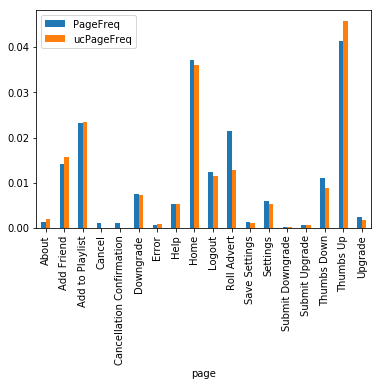

In [18]:
vizdf = churned_pagecounts.join(unchurned_pagecounts, "page", "outer").drop("count").fillna(0) \
    .where(churned_pagecounts.page != "NextSong").toPandas()
vizdf.plot.bar("page")

This figure shows that the churned users is likely to roll advert a lot more than unchurned users. Also, the number of thumb up from unchurned user is higher.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In order to predict how would the user perform, I would extract the following features:
- Average number of songs listened between user rolls advert.
- Average time user skipped listening.
- Number of different songs a user has listened to.
- Frequency of access to each pages.
- Number of different artists that the user listened to.

Average number of songs listened between user rolls advert.

In [30]:
function = udf(lambda isadvert : int(isadvert == "Roll Advert"), IntegerType())

user_window = Window.partitionBy("userID").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

cusum = minidf_withchurn.where((minidf_withchurn.page == "NextSong") | (minidf_withchurn.page == "Roll Advert")) \
    .select("userID", "page", "ts") \
    .withColumn("rolladvert", function(col("page"))) \
    .withColumn("period", Fsum("rolladvert").over(user_window))

songbetweenad = cusum.where((cusum.page == "NextSong")) \
    .groupBy("userId", "period").agg({"period": "count"}) \
    .groupBy("userId").agg({"count(period)": "avg"}).withColumnRenamed("avg(count(period))", "avgSongBetweenAd")

songbetweenad.show()

+------+------------------+
|userId|  avgSongBetweenAd|
+------+------------------+
|100010|               5.5|
|200002|            48.375|
|   125|               8.0|
|   124|             815.8|
|    51|            2111.0|
|     7| 8.823529411764707|
|    15|             957.0|
|    54|  60.4468085106383|
|   155| 91.11111111111111|
|100014| 85.66666666666667|
|   132| 642.6666666666666|
|   154|               8.4|
|   101|199.66666666666666|
|    11| 16.58974358974359|
|   138|             115.0|
|300017| 302.6666666666667|
|100021| 7.931034482758621|
|    29|131.65217391304347|
|    69|            281.25|
|   112| 9.772727272727273|
+------+------------------+
only showing top 20 rows



Average time user skipped to listen

In [31]:
user_session_songs = minidf_withchurn.where(minidf_withchurn.page == "NextSong").groupby("userId", "sessionId").count()
diff_window = Window.partitionBy("userId", "sessionId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)

timesum = minidf_withchurn.where(minidf_withchurn.page == "NextSong") \
    .select("userId", "page", "length", "ts", "sessionId") \
    .withColumn("timelistened", Fsum("length").over(diff_window))
timesum.show()

sessiontsdiff = timesum.groupby("userId", "sessionId") \
    .agg((Fmax(timesum.ts) - Fmin(timesum.ts)) / 1000) \
    .withColumnRenamed("((max(ts) - min(ts)) / 1000)", "tspassed")
sessiontsdiff.show()

sessionltimediff = timesum.groupBy("userId", "sessionId") \
    .agg(Fmax(timesum.timelistened)) \
    .withColumnRenamed("max(timelistened)", "timelistened")
sessionltimediff.show()

timeinfodf = sessiontsdiff.join(sessionltimediff, ["userId", "sessionId"])
timeinfodf.show()

skippedtimedf = timeinfodf.withColumn("skipedtime", timeinfodf.timelistened - timeinfodf.tspassed)
skippedtimedf.show()

skippedtimeavg = skippedtimedf.groupBy("userId").agg({"skipedtime": "avg"}).withColumnRenamed("avg(skipedtime)", "avgSkipTime")
skippedtimeavg.show()

+------+--------+---------+-------------+---------+------------------+
|userId|    page|   length|           ts|sessionId|      timelistened|
+------+--------+---------+-------------+---------+------------------+
|   101|NextSong|180.40118|1539065912000|      635|         180.40118|
|   101|NextSong|228.28363|1539066092000|      635|408.68480999999997|
|   101|NextSong|209.29261|1539066320000|      635| 617.9774199999999|
|   101|NextSong|226.19383|1539066529000|      635| 844.1712499999999|
|   101|NextSong|290.84689|1539066755000|      635|        1135.01814|
|   101|NextSong|189.93587|1539067045000|      635|        1324.95401|
|   101|NextSong|256.86159|1539067234000|      635|         1581.8156|
|   101|NextSong|197.66812|1539067490000|      635|        1779.48372|
|   101|NextSong| 278.7522|1539067687000|      635|        2058.23592|
|   101|NextSong|231.23546|1539067965000|      635|        2289.47138|
|   101|NextSong|304.84853|1539068196000|      635|        2594.31991|
|   10

Number of different songs a user has listened to.

In [32]:
useruniqsongcount = minidf_withchurn.where(minidf_withchurn.song != "null") \
    .select("userId", "song").dropDuplicates() \
    .groupBy("userId").count().withColumnRenamed("count", "UniqueSongCount")
useruniqsongcount.show()

usersongcount = minidf_withchurn.where(minidf_withchurn.song != "null") \
    .select("userId", "song").groupBy("userId").count().withColumnRenamed("count", "TotalSongCount")
usersongcount.show()

useruniqartistcount = minidf_withchurn.where(minidf_withchurn.artist != "null") \
    .select("userId", "artist").dropDuplicates() \
    .groupBy("userId").count().withColumnRenamed("count", "UniqueArtistCount")
useruniqartistcount.show()

+------+---------------+
|userId|UniqueSongCount|
+------+---------------+
|100010|            269|
|200002|            378|
|   125|              8|
|    51|           1854|
|   124|           3339|
|     7|            148|
|    15|           1707|
|    54|           2414|
|   155|            759|
|   132|           1718|
|100014|            248|
|   154|             83|
|   101|           1608|
|    11|            616|
|   138|           1791|
|300017|           3013|
|    29|           2562|
|    69|           1036|
|100021|            226|
|   112|            211|
+------+---------------+
only showing top 20 rows

+------+--------------+
|userId|TotalSongCount|
+------+--------------+
|100010|           275|
|200002|           387|
|   125|             8|
|    51|          2111|
|   124|          4079|
|     7|           150|
|    54|          2841|
|    15|          1914|
|   155|           820|
|   132|          1928|
|   154|            84|
|100014|           257|
|   101|      

Frequency of access to each pages.

In [35]:
# Firstly get each page counts for every user.
allpages = [(row["page"]) for row in minidf_withchurn.select("page").dropDuplicates().collect()]

# Remove pages representing churn
allpages.remove("Cancel")
allpages.remove("Cancellation Confirmation")

dfwithpagecount = minidf_withchurn \
    .where((minidf_withchurn.page != "Cancel") & (minidf_withchurn.page != "Cancellation Confirmation")) \
    .groupby("userId").count().withColumnRenamed("count", "totalcount")

for pagename in allpages:
    columnname =  pagename.replace(" ", "") + "count"
    singlepagecount = minidf_withchurn.where(minidf_withchurn.page == pagename).groupby("userId").count()
    singlepagecount = singlepagecount.withColumnRenamed("count", columnname)
    dfwithpagecount = dfwithpagecount.join(singlepagecount, "userId", "left")

dfwithpagecount = dfwithpagecount.fillna(0)
dfwithpagecount.show()

+------+----------+--------------------+---------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+--------------+-------------+-------------+---------+------------+----------+------------------+
|userId|totalcount|SubmitDowngradecount|ThumbsDowncount|Homecount|Downgradecount|RollAdvertcount|Logoutcount|SaveSettingscount|Aboutcount|Settingscount|AddtoPlaylistcount|AddFriendcount|NextSongcount|ThumbsUpcount|Helpcount|Upgradecount|Errorcount|SubmitUpgradecount|
+------+----------+--------------------+---------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+--------------+-------------+-------------+---------+------------+----------+------------------+
|100010|       381|                   0|              5|       11|             0|             52|          5|                0|         1|            0|                 7|             4|          

We also need the labels for supervised learning

In [34]:
labels = minidf_withchurn.select("userId", "churn").dropDuplicates()
labels.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



Finally we combine all these features together and save it so that the the data doesn't need to be recomputed.

In [40]:
featuredf = labels.join(songbetweenad, "userId", "left") \
    .join(skippedtimeavg, "userId", "left") \
    .join(useruniqsongcount, "userId", "left") \
    .join(usersongcount, "userId", "left") \
    .join(useruniqartistcount, "userId", "left") \
    .join(dfwithpagecount, "userId", "left")

featuredf.show()

+------+-----+------------------+-------------------+---------------+--------------+-----------------+----------+--------------------+---------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+--------------+-------------+-------------+---------+------------+----------+------------------+
|userId|churn|  avgSongBetweenAd|        avgSkipTime|UniqueSongCount|TotalSongCount|UniqueArtistCount|totalcount|SubmitDowngradecount|ThumbsDowncount|Homecount|Downgradecount|RollAdvertcount|Logoutcount|SaveSettingscount|Aboutcount|Settingscount|AddtoPlaylistcount|AddFriendcount|NextSongcount|ThumbsUpcount|Helpcount|Upgradecount|Errorcount|SubmitUpgradecount|
+------+-----+------------------+-------------------+---------------+--------------+-----------------+----------+--------------------+---------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+-----------

In [39]:
featuredf.write.csv("features.csv", header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
featuredf = spark.read.csv("features.csv", header=True)
featuredf.persist()


featurecolumns = featuredf.columns[1:]
for col_name in featurecolumns:
    featuredf = featuredf.withColumn(col_name, col(col_name).cast("float"))

assembler = VectorAssembler(inputCols = featuredf.columns[2:], outputCol = "NumFeatures", handleInvalid = "skip")
featuredf = assembler.transform(featuredf)

scaler = StandardScaler(inputCol = "NumFeatures", outputCol = "ScaledNumFeatures", withStd = True)
scalerModel = scaler.fit(featuredf)
featuredf = scalerModel.transform(featuredf)

getWeight = udf(lambda label: float(10 if (label == 1.0) else 1), FloatType())
featuredf = featuredf.withColumn("weight", getWeight(featuredf.churn))

featuredf.show()

+------+-----+----------------+-----------+---------------+--------------+-----------------+----------+--------------------+---------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+--------------+-------------+-------------+---------+------------+----------+------------------+--------------------+--------------------+------+
|userId|churn|avgSongBetweenAd|avgSkipTime|UniqueSongCount|TotalSongCount|UniqueArtistCount|totalcount|SubmitDowngradecount|ThumbsDowncount|Homecount|Downgradecount|RollAdvertcount|Logoutcount|SaveSettingscount|Aboutcount|Settingscount|AddtoPlaylistcount|AddFriendcount|NextSongcount|ThumbsUpcount|Helpcount|Upgradecount|Errorcount|SubmitUpgradecount|         NumFeatures|   ScaledNumFeatures|weight|
+------+-----+----------------+-----------+---------------+--------------+-----------------+----------+--------------------+---------------+---------+--------------+---------------+-----------+-----

In [4]:
# Create data and split data to train, test and validation
data = featuredf.select(col("churn").alias("label"), col("ScaledNumFeatures").alias("features"), col("weight"))

train, test = data.randomSplit([0.8, 0.2], seed = 27)
train2, test2 = data.randomSplit([0.8, 0.2], seed = 42)
train3, test3 = data.randomSplit([0.8, 0.2], seed = 3)
train = train.cache()
train2 = train2.cache()
train3 = train3.cache()
train.groupby("label").count().show()
test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   37|
|  0.0|  146|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   15|
|  0.0|   27|
+-----+-----+



In [5]:
def GetF1Score(model, testdata):
    # Formula from wikipedia https://en.wikipedia.org/wiki/F1_score
    result = model.transform(testdata)
    #result.show()
    tpcount = result.where((result.label == 1) & (result.prediction == 1)).count()
    fpcount = result.where((result.label == 0) & (result.prediction == 1)).count()
    fncount = result.where((result.label == 1) & (result.prediction == 0)).count()
    precision = 0
    recall = 0
    f1score = 0
    if (tpcount + fpcount) != 0:
        precision = tpcount / (tpcount + fpcount) 
    if (tpcount + fncount) != 0:
        recall = tpcount / (tpcount + fncount)
    if (precision + recall) != 0:
        f1score = 2 * precision * recall / (precision + recall)
    return f1score

In [6]:
def AutoTuneModel(model, paramgrid, traindata, testdata, kfold):
    cv = CrossValidator(estimator = model,
                        estimatorParamMaps = paramgrid,
                        evaluator = BinaryClassificationEvaluator(),
                        numFolds = kfold)

    model = cv.fit(train)
    print(model.avgMetrics)
    print(GetF1Score(model.bestModel, train))
    print(GetF1Score(model.bestModel, test))
    return model

In [9]:
# Logistic regression
lr = LogisticRegression(maxIter = 500, family = "binomial", weightCol = "weight")
initmodellr = lr.fit(train)
print(initmodellr.summary)
print(GetF1Score(initmodellr, test))

pglr = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0, 0.5, 1]) \
    .addGrid(lr.regParam,[0.001, 0.01, 0.1, 1, 10, 100]) \
    .build()


modellr = AutoTuneModel(lr, pglr, train, test, 5)
modellr2 = AutoTuneModel(lr, pglr, train2, test2, 5)
modellr3 = AutoTuneModel(lr, pglr, train3, test3, 5)

0.6363636363636364
[0.5025166191832858, 0.5358115341448675, 0.5293673918673919, 0.49490848657515324, 0.5169840499007166, 0.5207721445221445, 0.5027503669170336, 0.5366926746093412, 0.5568425170508504, 0.5, 0.5, 0.5, 0.5082590865924199, 0.5376136363636363, 0.5233620931537598, 0.5, 0.5, 0.5]
0.34418604651162793
0.5357142857142857
[0.5025166191832858, 0.5358115341448675, 0.5293673918673919, 0.49490848657515324, 0.5169840499007166, 0.5207721445221445, 0.5027503669170336, 0.5366926746093412, 0.5568425170508504, 0.5, 0.5, 0.5, 0.5082590865924199, 0.5376136363636363, 0.5233620931537598, 0.5, 0.5, 0.5]
0.34418604651162793
0.5357142857142857
[0.5025166191832858, 0.5358115341448675, 0.5293673918673919, 0.49490848657515324, 0.5169840499007166, 0.5207721445221445, 0.5027503669170336, 0.5366926746093412, 0.5568425170508504, 0.5, 0.5, 0.5, 0.5082590865924199, 0.5376136363636363, 0.5233620931537598, 0.5, 0.5, 0.5]
0.34418604651162793
0.5357142857142857


In [10]:
modellr.write().overwrite().save("lr.model")

In [11]:
# Random Forest
rf = RandomForestClassifier(seed = 42, maxBins = 2)
initmodelrf = rf.fit(train)
print(GetF1Score(initmodelrf, test))

pgrf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [250, 500, 750, 1000]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .build()

modelrf = AutoTuneModel(rf, pgrf, train, test, 5)
modelrf2 = AutoTuneModel(rf, pgrf, train2, test2, 5)
modelrf3 = AutoTuneModel(rf, pgrf, train3, test3, 5)

0
[0.5156498748165415, 0.5333055987222654, 0.5333055987222654, 0.5333055987222654, 0.49957696624363285, 0.5066404428904429, 0.5084151342484676, 0.5084151342484676, 0.5082447336614003, 0.515607787274454, 0.5142399421566088, 0.5142399421566088, 0.49636903220236556, 0.51627849002849, 0.5148896011396011, 0.5148896011396011]
0.6037735849056604
0
[0.5156498748165415, 0.5333055987222654, 0.5333055987222654, 0.5333055987222654, 0.49957696624363285, 0.5066404428904429, 0.5084151342484676, 0.5084151342484676, 0.5082447336614003, 0.515607787274454, 0.5142399421566088, 0.5142399421566088, 0.49636903220236556, 0.51627849002849, 0.5148896011396011, 0.5148896011396011]
0.6037735849056604
0
[0.5156498748165415, 0.5333055987222654, 0.5333055987222654, 0.5333055987222654, 0.49957696624363285, 0.5066404428904429, 0.5084151342484676, 0.5084151342484676, 0.5082447336614003, 0.515607787274454, 0.5142399421566088, 0.5142399421566088, 0.49636903220236556, 0.51627849002849, 0.5148896011396011, 0.51488960113960

In [12]:
modelrf.write().overwrite().save("rf.model")

In [7]:
# SVCClassifier
svm = LinearSVC(maxIter = 100, weightCol = "weight")
initmodelsvm = svm.fit(train)
print(GetF1Score(initmodelsvm, test))

pgsvm = ParamGridBuilder() \
    .addGrid(svm.maxIter, [50, 100, 150, 200]) \
    .addGrid(svm.regParam,[0.01, 0.1, 1, 10]) \
    .build()

modelsvm = AutoTuneModel(svm, pgsvm, train, test, 5)
modelsvm2 = AutoTuneModel(svm, pgsvm, train2, test2, 5)
modelsvm3 = AutoTuneModel(svm, pgsvm, train3, test3, 5)

0.625
[0.5503646199298373, 0.5503931482192352, 0.5316027979071457, 0.5344720844720845, 0.5502313915357393, 0.5582941441637094, 0.5418355461833723, 0.5553393933828716, 0.5517465430508909, 0.5567497426193078, 0.5452025495503756, 0.5647052690530951, 0.5546853514244819, 0.5582648941344593, 0.5452025495503756, 0.566557120904947]
0.33636363636363636
0.5263157894736842
[0.5503646199298373, 0.5503931482192352, 0.5316027979071457, 0.5344720844720845, 0.5502313915357393, 0.5582941441637094, 0.5418355461833723, 0.5553393933828716, 0.5517465430508909, 0.5567497426193078, 0.5452025495503756, 0.5647052690530951, 0.5546853514244819, 0.5582648941344593, 0.5452025495503756, 0.566557120904947]
0.33636363636363636
0.5263157894736842
[0.5503646199298373, 0.5503931482192352, 0.5316027979071457, 0.5344720844720845, 0.5502313915357393, 0.5582941441637094, 0.5418355461833723, 0.5553393933828716, 0.5517465430508909, 0.5567497426193078, 0.5452025495503756, 0.5647052690530951, 0.5546853514244819, 0.5582648941344

In [8]:
modelsvm.write().overwrite().save("svm.model")

In [6]:
lrmodel = CrossValidatorModel.load("lr.model")
rfmodel = CrossValidatorModel.load("rf.model")
svmmodel = CrossValidatorModel.load("svm.model")

The result doesn't look promising. This could be due to the fact that the data volume is too small. From the training result, we can look into what field is contributing to the decision most. The best model for now is the random forest.

In [10]:
rfmodel.bestModel.featureImportances

SparseVector(23, {0: 0.1389, 1: 0.1017, 2: 0.0434, 3: 0.0197, 4: 0.0065, 5: 0.0282, 7: 0.0594, 8: 0.0575, 9: 0.0638, 10: 0.0607, 11: 0.0535, 12: 0.0129, 13: 0.0484, 14: 0.0236, 15: 0.0612, 16: 0.0573, 17: 0.0266, 18: 0.0688, 19: 0.0152, 20: 0.0333, 21: 0.0126, 22: 0.0068})

In [11]:
featuredf.columns

['userId',
 'churn',
 'avgSongBetweenAd',
 'avgSkipTime',
 'UniqueSongCount',
 'TotalSongCount',
 'UniqueArtistCount',
 'totalcount',
 'SubmitDowngradecount',
 'ThumbsDowncount',
 'Homecount',
 'Downgradecount',
 'RollAdvertcount',
 'Logoutcount',
 'SaveSettingscount',
 'Aboutcount',
 'Settingscount',
 'AddtoPlaylistcount',
 'AddFriendcount',
 'NextSongcount',
 'ThumbsUpcount',
 'Helpcount',
 'Upgradecount',
 'Errorcount',
 'SubmitUpgradecount',
 'NumFeatures',
 'ScaledNumFeatures']

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.